In [1]:
pwd

'/root/fastai/Playground/PytorchStarter/Notebooks'

In [2]:
ls ../data/

breast-cancer-wisconsin.data.csv  names_test.csv.gz   raw/
diabetes.csv.gz                   names_train.csv.gz  shakespeare.txt.gz


In [3]:
import pdb
import types
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt


def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [4]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'pdb',
 'types',
 'torch',
 'torch.nn',
 'torch.optim',
 'torch.nn.functional',
 'numpy',
 'matplotlib.pyplot']

In [5]:
# Globals
RSEED = 11

## Data load

In [6]:
x_data = torch.Tensor([[1,2,3,4]]).view(4,1)
y_data = torch.Tensor([0,0,1,1]).view(4,1)

In [7]:
print(x_data, '\n', y_data)

tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.]]) 
 tensor([[ 0.],
        [ 0.],
        [ 1.],
        [ 1.]])


Load diabetes dataset

In [8]:
xy = np.loadtxt('../data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
print(xy.shape); print(xy)

(759, 9)
[[-0.294118   0.487437   0.180328  ... -0.53117   -0.0333333  0.       ]
 [-0.882353  -0.145729   0.0819672 ... -0.766866  -0.666667   1.       ]
 [-0.0588235  0.839196   0.0491803 ... -0.492741  -0.633333   0.       ]
 ...
 [-0.411765   0.21608    0.180328  ... -0.857387  -0.7        1.       ]
 [-0.882353   0.266332  -0.0163934 ... -0.768574  -0.133333   0.       ]
 [-0.882353  -0.0653266  0.147541  ... -0.797609  -0.933333   1.       ]]


In [9]:
X = xy[:,:-1]; print(X.shape)
y = xy[:,-1]; print(y.shape)

(759, 8)
(759,)


In [10]:
X = torch.from_numpy(X) #share the same memory 
y = torch.from_numpy(y)

Train and test set


### Custom data loader

In [11]:
from torch.utils.data import Dataset, DataLoader
class DiabetesDataset(Dataset):
    def __init__(self, ids):
        # Ideally we wouldn't load all data here.
        # Rather, read each file when __getitem__ is called
        xy = np.loadtxt('../data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
        self.x_data = xy[:,:-1]
        self.y_data = xy[:, -1]
        
        self.ids = ids
        self.len = len(ids)

        
    def __getitem__(self, idx):
        "Returns a sample in the format of [x_data[ID], y_data[ID]]"
#         print("idx: ", idx)
        ID = self.ids[idx]
        return self.x_data[ID,:], self.y_data[ID]
    
    def __len__(self):
        return self.len
    

#### First, partition the dataset into train, dev, test sets

In [71]:
from sklearn.model_selection import train_test_split
labels = y.numpy()
indices = range(len(labels))
train_dev_ids, test_ids = train_test_split(indices,
                                        stratify=labels,
                                        test_size=0.33, 
                                        random_state=RSEED) #stratified 

In [72]:
def check_ratio(indices, labels):
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
        
    print(sum(filtered==0)/sum(filtered==1))
# train_ids, dev_ids = train_test_split(tr_dev_ids, test_size=0.5, random_state=RSEED)

In [73]:
check_ratio(train_dev_ids, labels)
check_ratio(test_ids, labels)

0.5301204819277109
0.5304878048780488


In [89]:
# partition train_ids into train_ids and dev_ids
train_dev_labels = labels[train_dev_ids]
indices = range(len(train_dev_ids))
train_ids, dev_ids = train_test_split(indices, 
                                     stratify=train_dev_labels,
                                     test_size=0.5,
                                     random_state=RSEED)
imax = max(max(train_ids, dev_ids))
imin = min(min(train_ids, dev_ids))
print(f"min and max indices should corresponds to 0 and {len(train_dev_labels)-1}: {imin, imax}")

# map it back to index to (the original) y
train_ids = np.array(train_dev_ids)[train_ids]
dev_ids = np.array(train_dev_ids)[dev_ids]

# make test_ids also a np array
test_ids = np.array(test_ids)

min and max indices should corresponds to 0 and 507: (0, 507)


In [97]:
# check ratios
for index_array in [train_ids, dev_ids, test_ids]:
    check_ratio(index_array, labels)
    
# intersection check
s1 = set(train_ids); s2 = set(dev_ids); s3 = set(test_ids)
assert( len(s1.intersection(s2).intersection(s3)) == 0)

0.5301204819277109
0.5301204819277109
0.5304878048780488


Woohoo!

In [92]:
partition = {'train': train_ids, 
             'dev': dev_ids, 
             'test': test_ids}
train_dataset = DiabetesDataset(partition['train'])
dev_dataset = DiabetesDataset(partition['dev'])
test_dataset = DiabetesDataset(partition['test'])

In [14]:
#2. new dataloader instance
data_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':4}
train_loader = DataLoader(dataset=train_dataset, **data_params)
# dev_loader = DataLoader(dataset=dev_dataset, **data_params)
test_loader = DataLoader(dataset=test_dataset, **data_params)

## Binary classifer model

In [15]:
# %run ../Notebook/data_loader2.ipynb

In [16]:
class BCModel(nn.Module):    
    def __init__(self, inDim, l1Dim, l2Dim, activation):
        """ 
        inDim: input dimension
        l1Dim: number of units in the first layer
        l2Dim: number of units in the second layer
        activation: (torch.nn.modules.activation) activation function instance
            eg.nn.Sigmoid() or nn.Relu()
        """
        super(BCModel, self).__init__()
        self.l1 = nn.Linear(inDim, l1Dim)
        self.l2 = nn.Linear(l1Dim, l2Dim)
        self.l3 = nn.Linear(l2Dim, 1)
        
        # Hidden layers' activation
#         self.relu = nn.ReLU() #elementwise relu
        self.activation = activation
    
        # todo: batch norm layer
        
        # Last layer activation
        self.sigmoid = nn.Sigmoid() #elementwise sigmoid activation
        
    
    def forward(self, x):
        """input and output are both tensors"""
        out1 = self.activation(self.l1(x)) #todo: add batch norm layer
        out2 = self.activation(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred
    
    def print_params(self):
        for param in self.parameters():
            print(param)


Quick side note on nn.Sigmoid and nn.Softmax

1. `nn.Sigmoid` is best considered a softmax activation for a binary classification

In [17]:
sig = nn.Sigmoid()
x = torch.randn(4).view(4,-1) # 1D tensor of length 4
out = sig(x) # apply elementwise sigmoid function to x
print(out)
print(out.sum()) # doesn't make it a probability density along the dimension

tensor([[ 0.6728],
        [ 0.3191],
        [ 0.5742],
        [ 0.4609]])
tensor(2.0269)


2. `nn.Softmax` is a classifier layer that takes in a set of numbers and make them into a probability density along the specified dimension

In [18]:
softmax = nn.LogSoftmax(dim=1)
x = torch.randn(4,3) #4 data points, each of length 3
out = softmax(x)
print(out)
print(out.sum(dim=1))

tensor([[-2.1648, -1.7983, -0.3290],
        [-0.7956, -2.4270, -0.7756],
        [-0.6426, -2.4252, -0.9529],
        [-1.4593, -0.2988, -3.6547]])
tensor([-4.2921, -3.9983, -4.0207, -5.4127])


End of side

In [19]:
# Binary classification model
# set number of hidden units
H1 = 3
H2 = 4
learning_rate = 0.001

model = BCModel(X.shape[1], H1, H2, nn.Sigmoid())

In [20]:
model.print_params()

Parameter containing:
tensor([[ 0.2032,  0.3049,  0.2174,  0.2786, -0.1127,  0.1163,  0.0980,
          0.0840],
        [-0.3239, -0.2613, -0.2229,  0.0650, -0.0785, -0.2797,  0.2403,
         -0.0768],
        [ 0.3210, -0.0732, -0.2060, -0.3306,  0.2761,  0.2206, -0.0852,
         -0.0848]])
Parameter containing:
tensor([ 0.0119,  0.2984,  0.1386])
Parameter containing:
tensor([[ 0.3330,  0.0996, -0.3228],
        [-0.2135,  0.0689, -0.2524],
        [-0.3888,  0.2516,  0.0985],
        [-0.4387,  0.3469,  0.2224]])
Parameter containing:
tensor([-0.5216, -0.0515,  0.4249, -0.0195])
Parameter containing:
tensor([[ 0.1546,  0.2314, -0.1828,  0.3484]])
Parameter containing:
tensor([ 0.1434])


In [21]:
# loss and optimizer
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [22]:
# Training loop
ls = []
for epoch in range(100):
    #Forward entire dataset
    y_pred = model(X)
    
    #Compute loss
    l = criterion(y_pred, y)
    ls.append(l)
    
    if epoch%10 == 0:print(f"Epoch {epoch}: {l}")
    
    #Clear any accumulated gradients
    optimizer.zero_grad()
    
    #Backprop
    l.backward() 
    # now each parameter's .grad.data is set to the gradient from this 
    # forward pass
    
    #Update parameters
    optimizer.step()
    # update each registered parameter using the parameter's 
    #.grad.data and learning rate

Epoch 0: 0.6525617837905884
Epoch 10: 0.652484655380249
Epoch 20: 0.6524090766906738
Epoch 30: 0.6523345708847046


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 40: 0.6522595286369324
Epoch 50: 0.6521856784820557
Epoch 60: 0.6521125435829163
Epoch 70: 0.6520404815673828
Epoch 80: 0.6519685983657837
Epoch 90: 0.6518980264663696


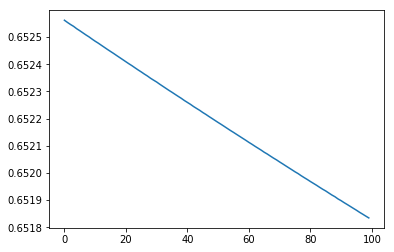

In [23]:
f, ax = plt.subplots()
ax.plot(ls)

# todo: 

[ ] model2: try softmax as activation  
[ ] add batchnorm layer to model1 and model2  
[ ] do  7-1

## 1. Compare activation functions 

In [24]:
# Wrong way to set initial weights 
# because no inplace functions are allowed for Variables with'requires_grad=True'
# Ref: https://discuss.pytorch.org/t/how-to-initiate-parameters-of-layers/1460
def wrong_weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.normal_() # error! 
        m.bias.normal_() # error!
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.data.normal_() 
        m.bias.data.normal_() 
            #alternatively set initial bias to zero
            # m.bias.data.fill_(0)
        

Sigmoid
initial weights: 
error: (tensor(1.0115), tensor(0.9651))
ReLU
initial weights: 
error: (tensor(1.9250), tensor(0.8557))
Softplus
initial weights: 


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


error: (tensor(1.7451), tensor(0.7730))


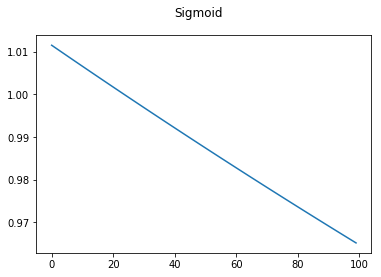

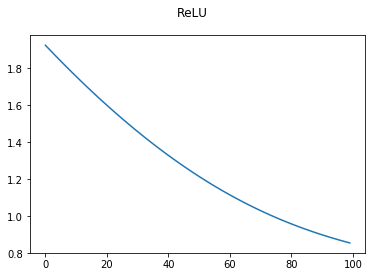

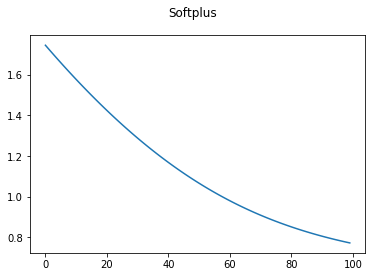

In [25]:
# BCEloss 
criterion = nn.BCELoss(size_average=True)

model_relu = BCModel(X.shape[1], H1, H2, nn.ReLU() )
acts = [nn.Sigmoid(), nn.ReLU(), nn.Softplus()]

for act in acts: 
    actname = act.__class__.__name__
    print(actname)
    model = BCModel(X.shape[1], H1, H2, activation=act)
    model.apply(weight_init)
    print("initial weights: ")
#     model.print_params()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train
    ls = []
    for epoch in range(100):
        #forward
        y_pred = model(X)
        
        #loss
        l = criterion(y_pred, y)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()
        
        #backward pass
        l.backward()
        
        #update parameters
        optimizer.step()
    f,ax = plt.subplots()
    f.suptitle(actname)
    ax.plot(ls)
    print(f"error: {ls[0], ls[-1]}")

Side: setting a random seed for pytorch
- Must set the seed before calling a random number generating function.

In [26]:
torch.manual_seed(2)
print(torch.rand(2))

torch.manual_seed(2)
print(torch.rand(2)) # gives the same random numbers

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


In [27]:
# However, thess will not.

torch.manual_seed(2)
print(torch.rand(2))

print(torch.rand(2))

tensor([ 0.6147,  0.3810])
tensor([ 0.6371,  0.4745])


In [28]:
# Set the seed manually right before calling the random generator 
for i in range(3):
    torch.manual_seed(2)
    print(torch.rand(2))
    

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


- Example: nn Linear module's weight initialization from a normal distribution with a random seed

In [29]:
print("original: \n", model.l1.weight.data)
print("normal call: \n", model.l1.weight.data.normal_())
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[-0.5209,  1.0293, -0.3506,  0.1164, -0.1888, -1.4995,  0.1282,
         -0.5361],
        [ 0.0801, -0.1853,  0.7937,  0.9629,  0.7823,  0.4834, -1.8192,
         -0.5442],
        [ 1.9123,  0.2977, -0.7049,  0.4994, -0.0474,  1.3253,  0.9269,
          0.2274]])
normal call: 
 tensor([[-1.3042, -1.1097, -1.2188,  1.1676, -1.0574, -0.1188, -0.3298,
          0.0958],
        [-1.1233, -0.0919, -0.1320, -0.2751, -0.2350,  0.0937, -0.7650,
          1.8299],
        [-0.1752,  0.6990, -0.6861,  0.7202,  0.1963,  0.6142,  1.1566,
          0.4296]])
normal call: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])


In [30]:
print("original: \n", model.l1.weight.data)
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])


End of side

## 2. Classifying with minibatch

initial weights: 


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


error: (tensor(1.4999), tensor(0.6525))


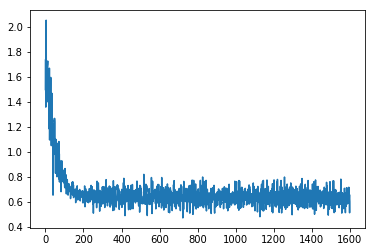

In [31]:
model = BCModel(X.shape[1], H1, H2, activation=act)
model.apply(weight_init)
print("initial weights: ")
# model.print_params()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train
ls = []
for epoch in range(100):
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Make them tensor
#         x_batch = torch.from_numpy(x_batch).type(torch.float)
#         y_batch = torch.from_numpy(y_batch).type(torch.float)
        #forward
        y_pred = model(x_batch)

        #loss
        l = criterion(y_pred, y_batch)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
f,ax = plt.subplots()
ax.plot(ls)
print(f"error: {ls[0], ls[-1]}")

Avg test batch loss: 0.634887520223856
Test accuracy:  0.6772908366533864


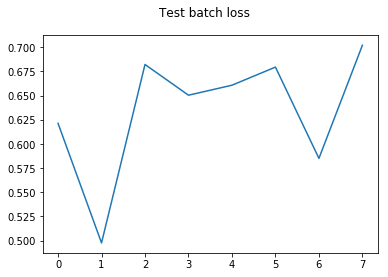

In [32]:
#Test loop
# test loss
test_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_ls.append(criterion(ypred_batch, ytest_batch).item())

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
#         pdb.set_trace()
        isCorrects.extend(isCorrect_batch)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    

Avg test batch loss: 0.6328511238098145
Test accuracy:  0.6772908366533864


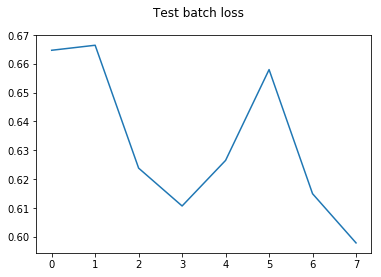

In [33]:
#Test loop
# test loss
test_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_ls.append(criterion(ypred_batch, ytest_batch).item())

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
#         pdb.set_trace()
        isCorrects.extend(isCorrect_batch)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    

Let's take a look at misclassified examples.

## 3. Try a deeper network

In [34]:
# %run ~/Workspace/

ERROR:root:File `'/root/Workspace/.py'` not found.


In [35]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, 
                 hidden_activation=nn.ReLU(), 
                 output_activation=nn.Sigmoid()):
        """
        dims: a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't includ the output layer's size, which is fixed to 1"""
        super(DeepBCModel,self).__init__()
        
        self.__build_layers__(dims)
        self.n_layers = len(dims)
        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_layers__(self, dims):
#         assert(len(self.layers) == 0)
#         for i in range(len(dims)-1):
#             self.add_module(f'h{i}', self.h_activation(nn.Linear(dims[i],dim[i+1])))
#         self.add_module(f'h{len(dim)-1}', self.o_activation(nn.Linear(dims[-1],1)))
                            
        for i in range(len(dims)-1):
            self.add_module(f'li{i}', (nn.Linear(dims[i],dims[i+1])))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
    def forward(self, x):
        y_pred = x
        
        for (mname, m) in self.named_children():
            if not isinstance(m, nn.Linear):
#                 print(mname, ': pass')
                continue
                
            if (str(self.n_layers-1) in mname):
#                 print(mname, ': last layer')
                act = self.o_activation
            else:
#                 print(mname, ": middle layer" )
                act = self.h_activation
                
            y_pred = act(m(y_pred))
        return y_pred
    

In [36]:
M = DeepBCModel([8,100,100,100])
print(M)
print(M.n_layers)

DeepBCModel(
  (li0): Linear(in_features=8, out_features=100, bias=True)
  (li1): Linear(in_features=100, out_features=100, bias=True)
  (li2): Linear(in_features=100, out_features=100, bias=True)
  (li3): Linear(in_features=100, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)
4


In [37]:
for m in M.children():
    print(m)

Linear(in_features=8, out_features=100, bias=True)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
ReLU()
Sigmoid()


In [38]:
# check forward function
dataiter = iter(train_loader)
x1, y1 = dataiter.next()

In [39]:
M(x1);

In [40]:
# Hyperparameters
learning_rate = 0.00001
nEpoch = 5000
H1 = 100; H2 = 100; H3 = 100; H4 = 100
dims = [X.shape[1], H1, H2, H3, H4]

In [41]:
model = DeepBCModel(dims)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# Train
train_ls = []
train_accs = []
for epoch in range(nEpoch):
#     print("="*30)
#     print(f'epoch {epoch}')
    train_isCorrects = [] 
    for i, (x_batch, y_batch) in enumerate(train_loader):

        #forward
        ypred_batch = model(x_batch).view(y_batch.size())
        
        #loss
        l = criterion(ypred_batch, y_batch)
        train_ls.append(l.item())
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).view(y_batch.size()).type(y_batch.dtype)
        # collect isCorrects
        isCorrect_batch = (decision_batch==y_batch).numpy()
#         print(decision_batch.size(),  isCorrect_batch.shape)
#         pdb.set_trace()
        batch_acc = sum(isCorrect_batch)/len(isCorrect_batch)
        train_accs.append(batch_acc)
#         print(f'\t batch{i} acc: {batch_acc}')
              
#     print(f'epoch{epoch} acc: {sum(train_accs)/len(train_accs)}')

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train batch losses: (12.088571548461914, 11.841866493225098)
Train accuracy: (0.5625, 0.5714285714285714)


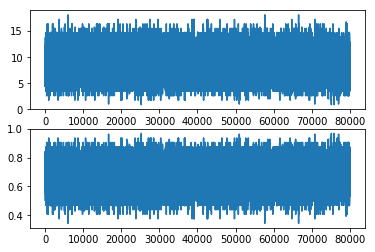

In [43]:
f,axes = plt.subplots(2,1)
axes[0].plot(train_ls)
axes[1].plot(train_accs)
print(f"Train batch losses: {train_ls[0], train_ls[-1]}")
print(f"Train accuracy: {train_accs[0], train_accs[-1]}")

Avg test batch loss: 9.226331412792206
Test accuracy:  0.6772908366533864


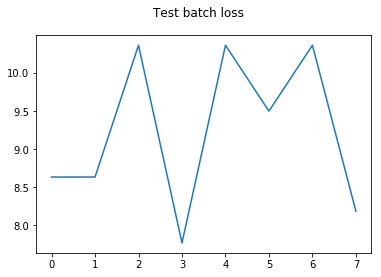

In [44]:
#Test loop
# test loss
test_ls = []
test_isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_ls.append(criterion(ypred_batch, ytest_batch).item())

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
#         pdb.set_trace()
        test_isCorrects.extend(isCorrect_batch)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    